## using treesignal on fungal root HOGs from OMA
- [version 2017.12.11] the species tree was found by guenomu's Bayesian run using some 230 rootHOGs. Tree looks good except for Talaromyces location
- [version 2018.02.06] species trees were found byML guenomu on rootHOG sets, where some are ~50 rootHOGs from largest to smallest but having > 46 species, and some are ~120 random rootHOGs (chosen by hand, a bit biased towards larger families). sptrees were good, changing root. 
- from original 2018.01.06 version: from the resulting 41 sptrees (with ~50 large fams), I emulated 5 genefams with them and applied lax ML to have further 20 sptrees from Bayes guenomu. From 'final' 2018.01.06 version (including best sptrees from some 30 random genfam sets) I just added 3 more 'random' trees, to round to 70 sptrees.
- there are ~11k gene families, 49 species. (The groups of some species are available from a PNAS paper if I want to colour the species tree)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy, glob, ete3, copy, gzip, pickle
from ete3 import TreeStyle
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

### Loading reference trees (sptrees)
[version 2017.12.11] noise.tre was generated from job0.unrooted.tre, adding noise twice with cummulative frequency of 40% (and maybe removing tail?). Total of 143 trees.

[version 2018.02.06] to create noise.tre I just use the 67 sptrees with 3 'random' ones (using sptrees as genefam and taking 3 less frequent trees...)

In [2]:
data_dir = "/home/leo/Academic/Projects/205.oma/fungi/"
f_dir = data_dir + "aligntree/*.treefile"
spfile = data_dir + "nexus/noise.tre" # guenomu output with addNoise
sptrees = dendropy.TreeList.get_from_path (spfile, "nexus", preserve_underscores=True)
#sptrees = sptrees[:100] # if you want to work if a fraction only

geneidx = int(2 * len(sptrees)) # this will be single index for all gene trees
print (len(sptrees))
ini = len(sptrees)  ## used later to split genetrees and sptrees

70


The code below *is not necessary* since *noise.tre* already has noise, and therefore the *script false* (works only on linux). But if you want to explicitly generate SPR neighbours, this is one way to do it. 

In [ ]:
###  %%script false  ## CODE BELOW IS NOT RUN
spstring = ""
for tree in sptrees[:50]:
    spstring += tree.as_string("newick",suppress_edge_lengths=True).rstrip().replace("'","")   
sptrees = treesignal.lowlevel_randomise_trees_with_spr_string(spstring, n_copies=1, n_spr=5)
sptrees = dendropy.TreeList.get(data=sptrees, schema="newick")
ini = len(sptrees)

### Calculate feature matrix rows using reference sptrees as samples 
* function yield_from_files allow several files to be read at once, and trees being read one by one
* the calculated distances are scaled using 'p-values' and also empirical MinMax (set using "replicates" parameter)
* version 2017.11.10 also uses 'observed' reference sptrees in p-value calculation. That is, if we have 100 sptrees and 200 random replicates, then p-value will be fraction of 300 trees.

In [3]:
ts = treesignal.TreeSignal(sp_trees = sptrees, replicates=100)

feat_mat = []
genesize = []
t_index  = []
t_sample = []

for idx, tre in enumerate(sptrees):
    spectrum = ts(tre)
    if spectrum.max() > -1.: # if genetree is too small etc. there is no spectrum
        feat_mat.append(spectrum)
        genesize.append(len(tre.leaf_nodes()))
        t_index.append(idx)
        t_sample.append(tre)

print (len(sptrees))
ini = len(sptrees)  ## used later to split genetrees and sptrees

70


### Read gene trees and update feature matrix rows 
* function yield_from_files allow several files to be read at once, and trees being read one by one

In [4]:
for counter, file in enumerate(glob.glob(f_dir)[:4000]):
    tyield = dendropy.Tree.yield_from_files(files=[file], schema="newick", preserve_underscores=True)
    for idx, tre in enumerate (tyield): # iterate over trees as it reads (not everything in memory at once)
        if idx > 0: # read only first trees
            break
        else:
            #print (tre.as_string("newick",suppress_edge_lengths=True).replace("'",""))
            spectrum = ts(tre)
            if spectrum.max() > -1.: # if genetree is too small etc. there is no spectrum
                feat_mat.append(spectrum)
                genesize.append(len(tre.leaf_nodes()))
                t_index.append(geneidx)
                t_sample.append(tre)
                if not counter%500:
                    print(counter, end=' ', flush=True)

# first gene trees, and sptrees last
feat_mat = np.array(feat_mat[::-1])
genesize = np.array(genesize[::-1])
t_index = np.array(t_index[::-1])
t_sample = np.array(t_sample[::-1])
print ("\ndimensions: ", feat_mat.shape) 

0 500 1000 1500 2000 2500 3000 3500 
dimensions:  (4005, 840)


In [5]:
# SAVE results
#testdir = "20171211.results_from_013/"
testdir = "20180206.results_from_013/"
fl=gzip.open(data_dir+testdir+"treesignal.pickle.gz", "w"); pickle.dump([feat_mat, genesize, t_index, t_sample],fl,2); fl.close()
# LOAD results
#fl=gzip.open(data_dir+testdir+"treesignal.pickle.gz", "r"); 
#feat_mat, genesize, t_index, t_sample = pickle.load(fl); fl.close()

In [5]:
def get_tree_sizes(tree):
    sp_names = [leaf.taxon.label[:5] for leaf in tree.leaf_nodes()]
    return set(sp_names), len(sp_names)

spnames = []
tsize = []
for tre in t_sample[:-ini]: # gene trees only (last 'ini' are reference sptrees)
    nm, sz = get_tree_sizes(tre)
    spnames.append(nm)
    tsize.append(sz)
common_species = [len(spnames[i].intersection(spnames[j])) for i in range(len(spnames)) for j in range(i)]

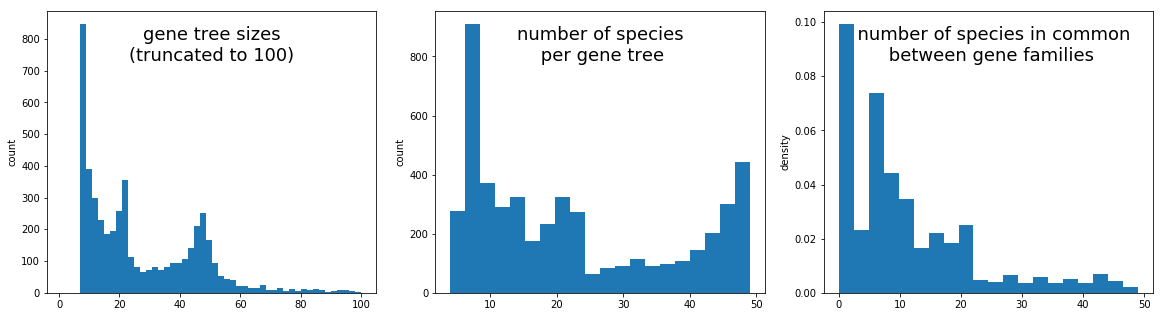

In [6]:
fig, axes = plt.subplots(1,3) ; fig.set_size_inches(16, 4)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.18, hspace=.18)
n_species_per_gene = [len(x) for x in spnames]
axes[0].hist(tsize, 50, range=[1,100])
axes[0].set_title("gene tree sizes\n(truncated to 100)", x=0.5, y=0.8, fontsize=18)
axes[0].set_ylabel("count")
axes[1].hist(n_species_per_gene, 20)
axes[1].set_title("number of species\n per gene tree", x=0.5, y=0.8, fontsize=18)
axes[1].set_ylabel("count")
axes[2].hist(common_species, 20, normed=True)
axes[2].set_title("  number of species in common\n between gene families", x=0.5, y=0.8, fontsize=18)
axes[2].set_ylabel("density")

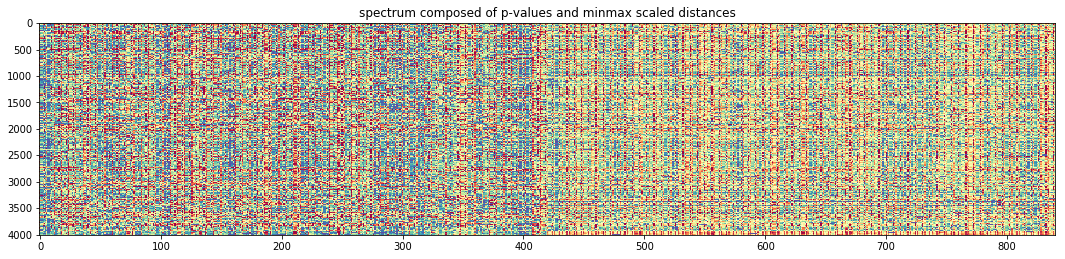

In [6]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(15,3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes.imshow(feat_mat ,aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes.set_title("spectrum composed of p-values and minmax scaled distances")

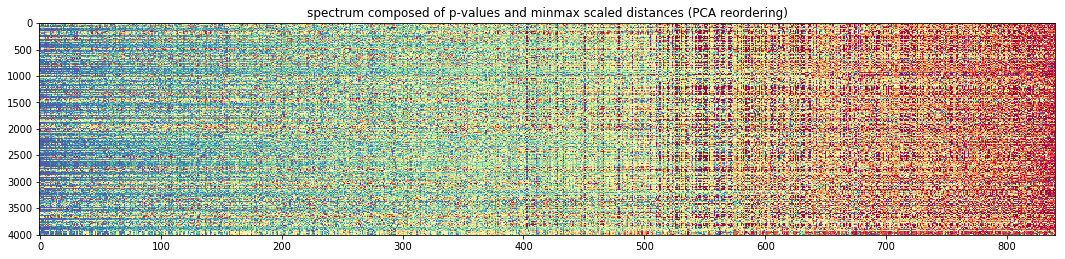

In [7]:
## order of the FEATURES (distances) using first PC 
feat_order = np.argsort(decomposition.PCA(n_components=2).fit_transform(feat_mat.T)[:,0])
fig, axes = plt.subplots(1) ; fig.set_size_inches(15,3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes.imshow(feat_mat[:,feat_order],aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes.set_title("spectrum composed of p-values and minmax scaled distances (PCA reordering)")

#### Standardisation and optional pruning
we discard first gene trees (last, in directory structure) and also discard p-valued dissimilarities

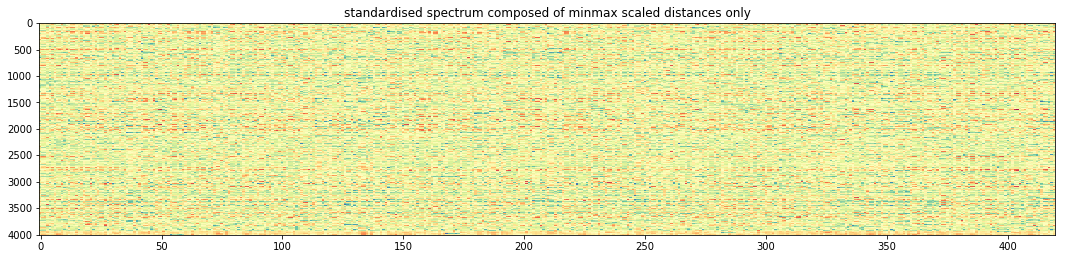

In [8]:
discard = 0 
genesize = genesize[discard:]; 
t_index  =  t_index[discard:]; 
t_sample = t_sample[discard:];

fmatrix = feat_mat[discard:,int(feat_mat.shape[1]/2):]
fmatrix = preprocessing.StandardScaler().fit_transform(fmatrix)
#fmatrix = feat_mat/feat_mat.mean(0)

fig, axes = plt.subplots(1) ; fig.set_size_inches(15,3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes.imshow(fmatrix ,aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes.set_title("standardised spectrum composed of minmax scaled distances only")

In [9]:
transf_I = manifold.Isomap(n_neighbors=8, n_components=2, n_jobs=-1).fit_transform(fmatrix)

In [14]:
transf_M = manifold.MDS(n_components=2, n_jobs=-1).fit_transform(fmatrix) ## slower than isomap and spectralEmbedding

In [10]:
transf_S = manifold.SpectralEmbedding(n_components=2, n_jobs=-1).fit_transform(fmatrix)

In [11]:
transf_P = decomposition.PCA(n_components=2).fit_transform(fmatrix)

In [12]:
transf_T = manifold.TSNE(n_components=2, perplexity=50, n_iter=1000).fit_transform(fmatrix)

#### Save manifolds to file

In [15]:
fl=gzip.open(data_dir+testdir+"transf_I.pickle.gz", "w"); pickle.dump([transf_I],fl,2); fl.close()
fl=gzip.open(data_dir+testdir+"transf_M.pickle.gz", "w"); pickle.dump([transf_M],fl,2); fl.close()
fl=gzip.open(data_dir+testdir+"transf_S.pickle.gz", "w"); pickle.dump([transf_S],fl,2); fl.close()
fl=gzip.open(data_dir+testdir+"transf_P.pickle.gz", "w"); pickle.dump([transf_P],fl,2); fl.close()
fl=gzip.open(data_dir+testdir+"transf_T.pickle.gz", "w"); pickle.dump([transf_T],fl,2); fl.close()

#### read manifolds from file

In [20]:
#fl=gzip.open(data_dir+testdir+"transf_I.pickle.gz", "r"); transf_I = np.array(pickle.load(fl)[0]); fl.close()
#fl=gzip.open(data_dir+testdir+"transf_M.pickle.gz", "r"); transf_M = np.array(pickle.load(fl)[0]); fl.close()
#fl=gzip.open(data_dir+testdir+"transf_S.pickle.gz", "r"); transf_S = np.array(pickle.load(fl)[0]); fl.close()
#fl=gzip.open(data_dir+testdir+"transf_P.pickle.gz", "r"); transf_P = np.array(pickle.load(fl)[0]); fl.close()
fl=gzip.open(data_dir+testdir+"transf_T.pickle.gz", "r"); transf_T = np.array(pickle.load(fl)[0]); fl.close()

In [18]:
print (transf_I.shape)
#transf_T = transf_P

(4005, 2)


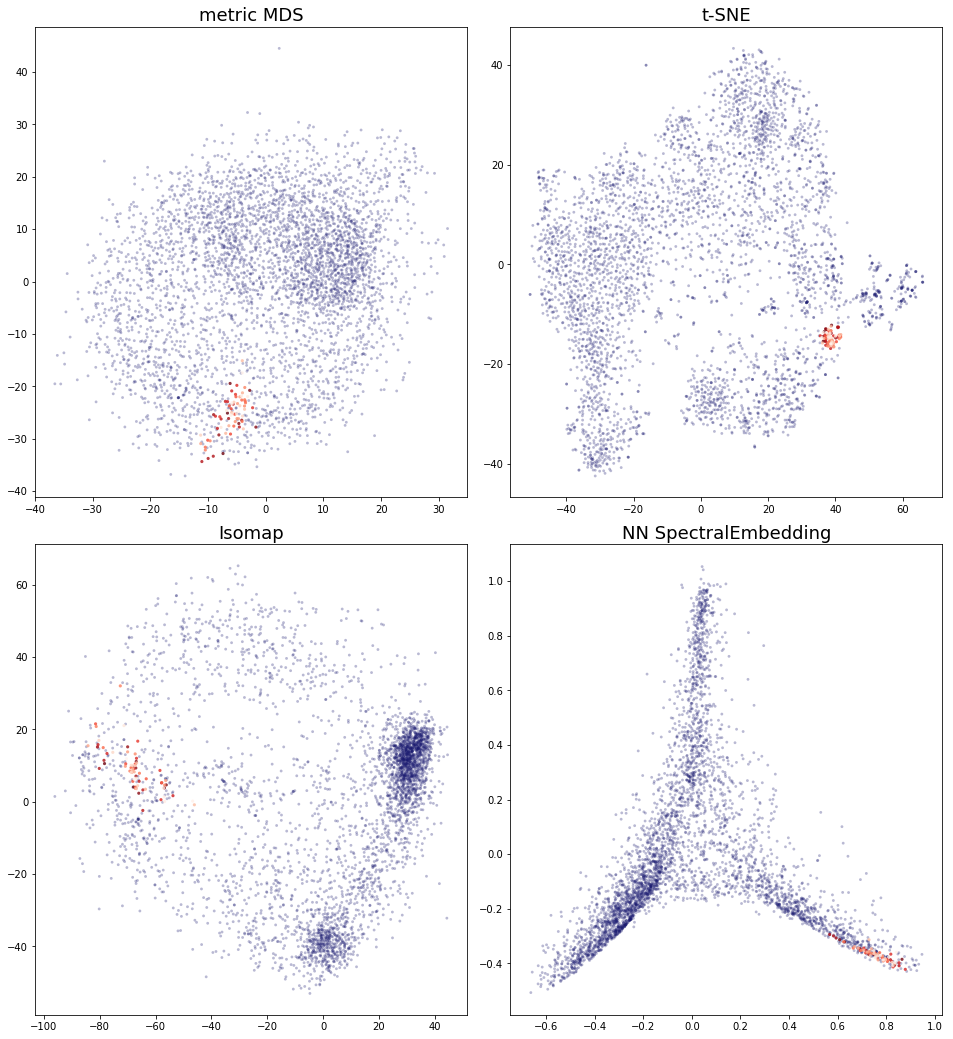

In [21]:
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(14, 14)
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.91, wspace=.1, hspace=.1)
cd1 = "midnightblue"; ad1 = .3; sd1 = 8; # gene trees
ad2 = 0.8; sd2 = 10; cmap_sp = "Reds"; # reference trees
axes[0,0].scatter(transf_M[:-ini,0], transf_M[:-ini,1], edgecolor="none", c = cd1, alpha=ad1, s=sd1)
axes[0,0].scatter(transf_M[-ini:,0], transf_M[-ini:,1], c=t_index[-ini:], edgecolor="none", cmap=cmap_sp, alpha=ad2, s=sd2)
axes[0,0].set_title("metric MDS",  fontsize=18)

axes[0,1].scatter(transf_T[:-ini,0], transf_T[:-ini,1], edgecolor="none", c = cd1, alpha=ad1, s=sd1)
axes[0,1].scatter(transf_T[-ini:,0], transf_T[-ini:,1], c=t_index[-ini:], edgecolor="none", cmap=cmap_sp, alpha=ad2, s=sd2)
axes[0,1].set_title("t-SNE",  fontsize=18)

axes[1,0].scatter(transf_I[:-ini,0], transf_I[:-ini,1], edgecolor="none", c = cd1, alpha=ad1, s=sd1)
axes[1,0].scatter(transf_I[-ini:,0], transf_I[-ini:,1], c=t_index[-ini:], edgecolor="none", cmap=cmap_sp, alpha=ad2, s=sd2)
axes[1,0].set_title("Isomap",  fontsize=18)

axes[1,1].scatter(transf_S[:-ini,0], transf_S[:-ini,1], edgecolor="none", c = cd1, alpha=ad1, s=sd1)
axes[1,1].scatter(transf_S[-ini:,0], transf_S[-ini:,1], c=t_index[-ini:], edgecolor="none", cmap=cmap_sp, alpha=ad2, s=sd2)
axes[1,1].set_title("NN SpectralEmbedding",  fontsize=18)

In [22]:
spname = dict([line.split() for line in open(data_dir+"02.spnames/species_names_long.txt")])
def treestring_with_spnames(tre_original):
    tre = copy.deepcopy(tre_original)
    for leaf in tre.leaf_nodes():
         leaf.taxon.label = spname[leaf.taxon.label[:5]]
    return tre.as_string(schema="newick").rstrip().replace("'","")

style = ete3.NodeStyle()
style["vt_line_color"] = "black"
style["hz_line_color"] = "black"
style["vt_line_width"] = 4
style["hz_line_width"] = 4

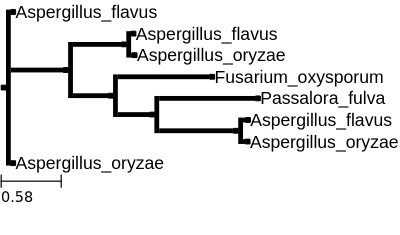

In [23]:
# could also apply PCA before: decomposition.PCA(n_components=2).fit_transform(transf_M)
t_o = np.argsort(transf_M[:,0]); # first positions will be the most positive with [::-1]
t = ete3.PhyloTree(treestring_with_spnames(t_sample[t_o[0]]))
for n in t.traverse():
    n.set_style(style)
tst = ete3.TreeStyle();
tst.optimal_scale_level = "mid"; tst.show_leaf_name = False; #tst.scale = 50
t.render("%%inline", w=400, tree_style=tst)

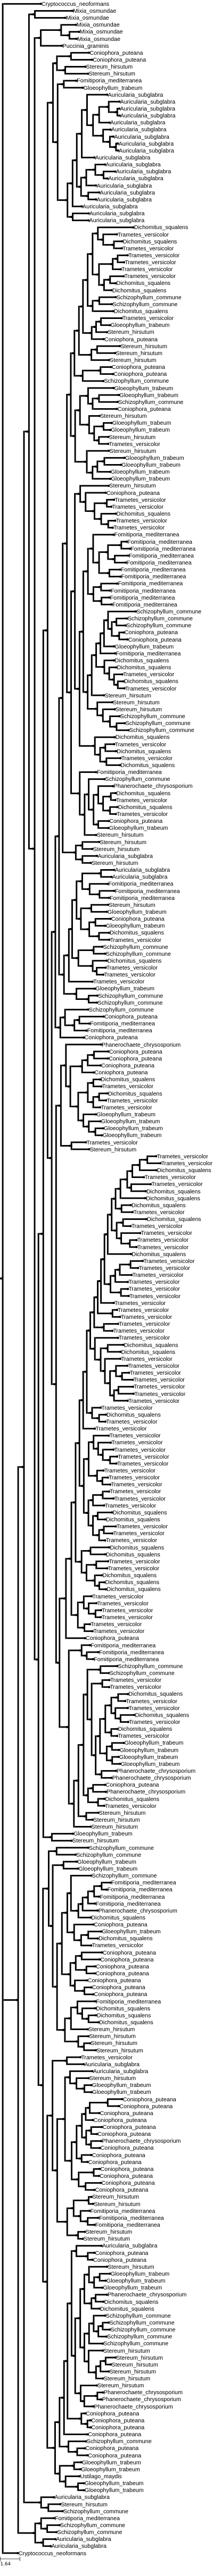

In [24]:
t = ete3.PhyloTree(treestring_with_spnames(t_sample[t_o[-1]]))
for n in t.traverse():
    n.set_style(style)
tst = ete3.TreeStyle();
tst.optimal_scale_level = "mid"; tst.show_leaf_name = False; #tst.scale = 50
t.render("%%inline", w=400, tree_style=tst)

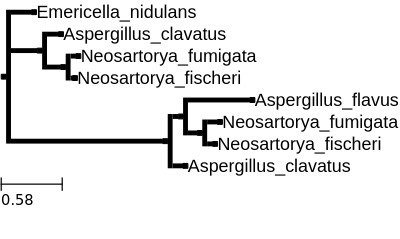

In [25]:
t_o = np.argsort(transf_M[:,1]); 
t = ete3.PhyloTree(treestring_with_spnames(t_sample[t_o[0]]))
for n in t.traverse():
    n.set_style(style)
tst = ete3.TreeStyle();
tst.optimal_scale_level = "mid"; tst.show_leaf_name = False; #tst.scale = 50
t.render("%%inline", w=400, tree_style=tst)

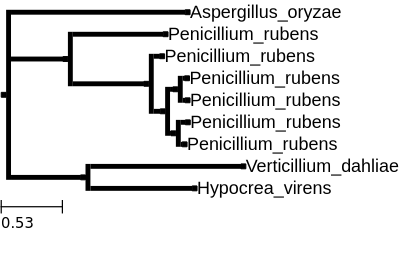

In [26]:
t = ete3.PhyloTree(treestring_with_spnames(t_sample[t_o[-1]]))
for n in t.traverse():
    n.set_style(style)
tst = ete3.TreeStyle();
tst.optimal_scale_level = "mid"; tst.show_leaf_name = False; #tst.scale = 50
t.render("%%inline", w=400, tree_style=tst)

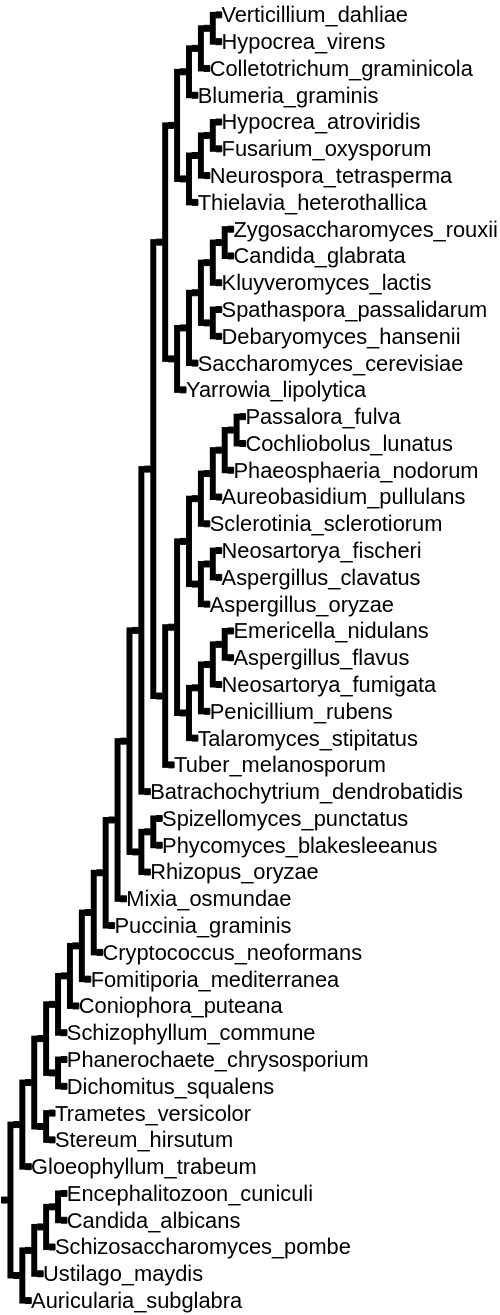

In [27]:
t = ete3.PhyloTree(treestring_with_spnames(t_sample[-1]))
for n in t.traverse():
    n.set_style(style)
#tst.arc_start = 0; tst.arc_span = 359;  tst.mode = "c";
tst = ete3.TreeStyle();
tst.show_scale = False; tst.optimal_scale_level = "full"; tst.show_leaf_name = False; #tst.scale = 50
t.render("%%inline", w=500, tree_style=tst)

# clustering

In [28]:
# standardise and find clusters for gene trees only
fmatrix = preprocessing.StandardScaler().fit_transform(feat_mat[:-ini])
db = cluster.DBSCAN(eps=15.).fit(fmatrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("labels: ", labels)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(fmatrix, labels))

labels:  [-1 -1  0 ...,  1 -1 -1]
Estimated number of clusters: 18
Silhouette Coefficient: -0.190


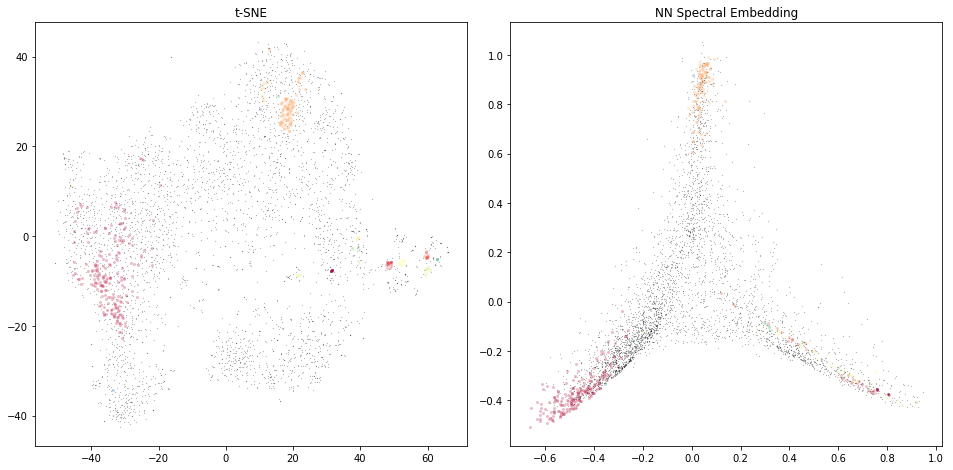

In [29]:
fig, axes = plt.subplots(1,2) ; fig.set_size_inches(14, 6)
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.91, wspace=.1, hspace=.1)
# when plotting we will use t-sne and Spectral Embedding projections of gene trees
Xt = transf_T[:-ini] # from first to (last - ini)
Xs = transf_S[:-ini] # from first to (last - ini)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black used for noise.
    class_member_mask = (labels == k)
    xy = Xt[class_member_mask & ~core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=0.1)
    xy = Xs[class_member_mask & ~core_samples_mask]
    axes[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=0.1)
    
    xy = Xt[class_member_mask & core_samples_mask]
    axes[0].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='none', alpha=0.3, markersize=3)
    xy = Xs[class_member_mask & core_samples_mask]
    axes[1].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='none', alpha=0.3, markersize=3)
    
axes[0].set_title('t-SNE'); axes[1].set_title('NN Spectral Embedding'); 

In [30]:
fmatrix = preprocessing.StandardScaler().fit_transform(feat_mat[:-ini])
nclusters_kmean = 5
kme=cluster.MiniBatchKMeans(init='k-means++', n_clusters=nclusters_kmean, batch_size=200,n_init=50).fit(fmatrix)

(4005, 2) [0 3 1 ..., 0 1 1] 70


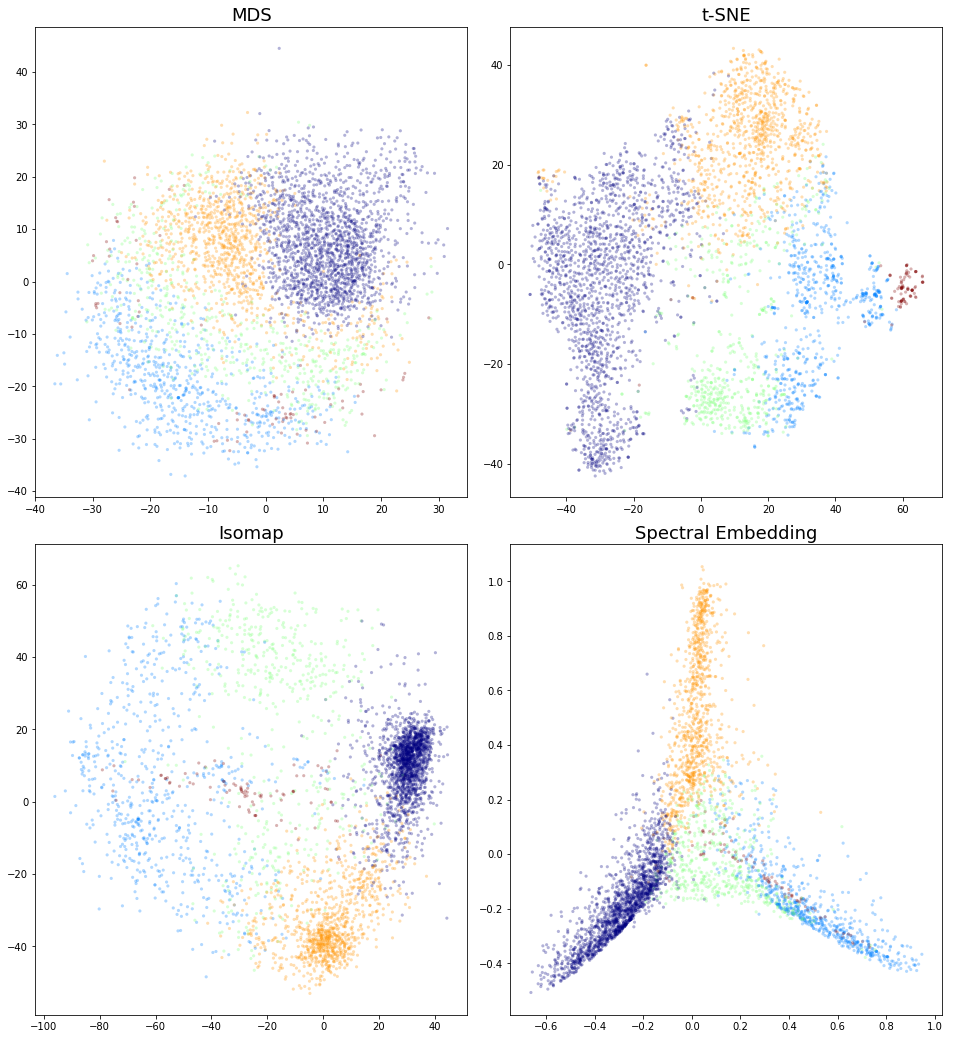

In [32]:
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(14,14)
fig.subplots_adjust(top=.99, bottom=.01, left=.01, right=.91, wspace=.1, hspace=.1)
ad1 = .3; sd1 = 10;
print (transf_M.shape, kme.labels_, ini)
axes[0,0].scatter(transf_M[:-ini,0], transf_M[:-ini,1], c=kme.labels_, edgecolor="none", cmap="jet", alpha=ad1, s=sd1)
#axes[0,0].scatter(transf_M[-ini:,0], transf_M[-ini:,1], c="white", edgecolor="black", s=10)
axes[0,0].set_title("MDS",  fontsize=18)

axes[0,1].scatter(transf_T[:-ini,0], transf_T[:-ini,1], c=kme.labels_, edgecolor="none", cmap="jet", alpha=ad1, s=sd1)
#axes[0,1].scatter(transf_T[-ini:,0], transf_T[-ini:,1],c="white", edgecolor="black", s=10)
axes[0,1].set_title("t-SNE",  fontsize=18)

axes[1,0].scatter(transf_I[:-ini,0], transf_I[:-ini,1], c=kme.labels_, edgecolor="none", cmap="jet", alpha=ad1, s=sd1)
#axes[1,0].scatter(transf_I[-ini:,0], transf_I[-ini:,1], c="white", edgecolor="black", s=10)
axes[1,0].set_title("Isomap",  fontsize=18)

axes[1,1].scatter(transf_S[:-ini,0], transf_S[:-ini,1], c=kme.labels_, edgecolor="none", cmap="jet", alpha=ad1, s=sd1)
#axes[1,1].scatter(transf_S[-ini:,0], transf_S[-ini:,1], c="white", edgecolor="black", s=10)
axes[1,1].set_title("Spectral Embedding",  fontsize=18)

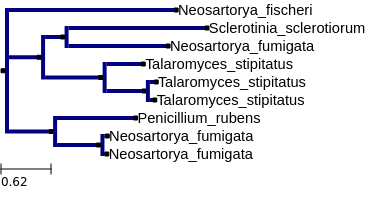

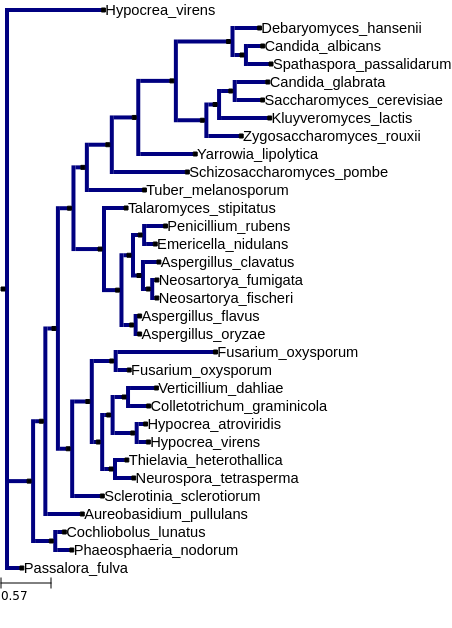

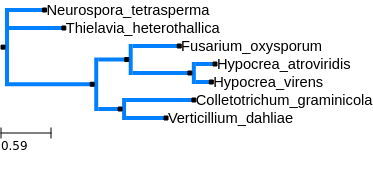

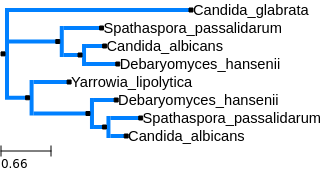

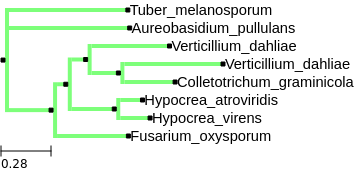

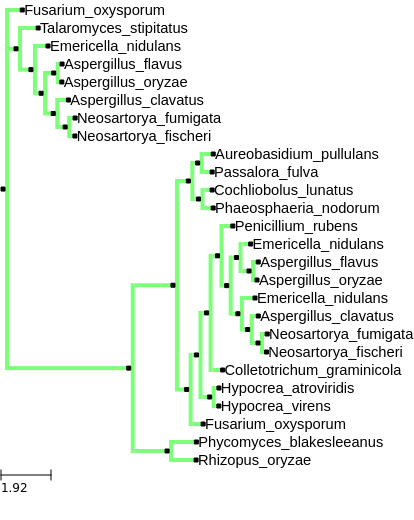

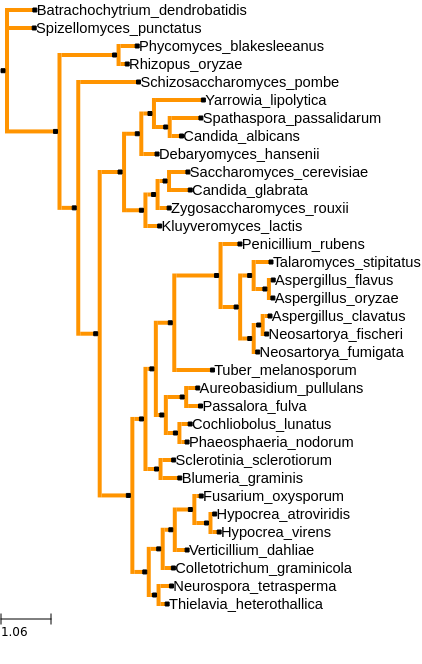

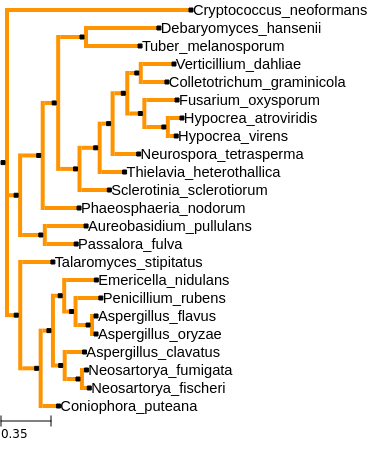

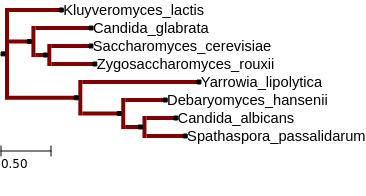

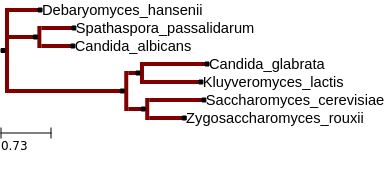

In [33]:
from IPython.display import display
cmap = matplotlib.cm.get_cmap('jet')
for i in range(nclusters_kmean):
    for j in range(2):
        tre = t_sample[np.where(kme.labels_ == i)[0][j]]  # WARNING: labels_ is relative to GENEtrees, while t_sample has ALL trees
        # create ete tree with colored branches
        t = ete3.PhyloTree(treestring_with_spnames(tre))    
        style = ete3.NodeStyle()
        style["vt_line_color"] = matplotlib.colors.to_hex(cmap(float(i)/float(nclusters_kmean - 1)))
        style["hz_line_color"] = matplotlib.colors.to_hex(cmap(float(i)/float(nclusters_kmean - 1)))
        style["vt_line_width"] = 4
        style["hz_line_width"] = 4
        for n in t.traverse():
            n.set_style(style)
        display(t.render("%%inline"))